# Stage 3 submission for Leena Godbole
## IAC-621
## Markdown report at bottom of notebook

Member:

Use the state data (the state of your choice) generated in Stage II to fit a distribution to the number of COVID-19 cases. (25 points)

Graphically plot the distribution and describe the distribution statistics. If using discrete values, calculate the Probability Mass Function for the individual values or range (if using histogram) and plot that.
Describe the type of distribution (modality) and its statistics (moments of a distribution - center, variance, skewness, kurtosis) in the report and the notebook.
Compare the distribution and its statistics to 5 other states of your choosing. Describe if the distributions look different and what does that imply.


Model a poission distribution of COVID-19 cases and deaths of a state and compare to other 5 states. Describe how the poission modeling is different from the first modeling you did. (25 points)

For example, number of new cases and deaths per 100,000 population.
Hint - the parameter for a poission's distribution will be its mean value. Then for the minimum and maximum range of covid cases you are calculating probability mass function to observe the probability at different points.

Perform corelation between Enrichment data valiables and COVID-19 cases to observe any patterns. (20 points)

You can compare either within your chosen specific state or among different states with the different enrichment variables. Within the state you can compare the county based covid data to enrichment data for correlation. Between states you would need to aggregate to state level data and then perform correlation. Both covid and enrichment data will need to be normalized for population. For number of covid cases you can use a measure of center value (median or mean) to compare the number of cases.
Formulate hypothesis between Enrichment data and number of cases to be compared against states. Choose 3 different variables to compare against. (30 points)

For example: Does higher employment data lead to higher covid case numbers or more rapid increase in covid cases.

In [1]:
# libraries & settings

import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
import datetime as dt

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('ProjectDataStage1WIDEFORMAT.csv')

In [3]:
# Function to summarize data frames
# mode is not an agg function in pandas, so we will have to create an alternate way to acieve that

def nullcounts(ser):
    return ser.isnull().sum()

def custom_describe(frame, func=[nullcounts, 'sum', 'mean', 'median', 'max'],
                    numeric_only=True, **kwargs):
    if numeric_only:
        frame = frame.select_dtypes(include=np.number)
    return frame.agg(func, **kwargs)

In [4]:
# Defining total poplutations
CApop = 39512223
ILpop = 12671821
WYpop = 578759
DEpop = 973764
KYpop = 4467673
MIpop = 9986857


# Filtering df to only contain values for a single state

dfCalifornia = df[df['State']=='CA']
dfIllinois = df[df['State']=='IL']
dfWyoming = df[df['State']=='WY']
dfDelaware = df[df['State']=='DE']
dfKentucky= df[df['State']=='KY']
dfMichigan = df[df['State']=='MI']


# Creating summary data for each state

dfCalifornia = custom_describe(dfCalifornia)
dfIllinois = custom_describe(dfIllinois)
dfWyoming = custom_describe(dfWyoming)
dfDelaware = custom_describe(dfDelaware)
dfKentucky= custom_describe(dfKentucky)
dfMichigan = custom_describe(dfMichigan)

# dropping state and county fips
dfCalifornia.drop(['countyFIPS', 'population'], inplace = True, axis = 1)
dfIllinois.drop(['countyFIPS', 'population'], inplace = True, axis = 1)
dfWyoming.drop(['countyFIPS', 'population'], inplace = True, axis = 1)
dfDelaware.drop(['countyFIPS', 'population'], inplace = True, axis = 1)
dfKentucky.drop(['countyFIPS', 'population'], inplace = True, axis = 1)
dfMichigan.drop(['countyFIPS', 'population'], inplace = True, axis = 1)

#Transposing data, so dates are row value
dfCalifornia = dfCalifornia.T
dfIllinois = dfIllinois.T
dfWyoming = dfWyoming.T
dfDelaware = dfDelaware.T
dfKentucky = dfKentucky.T
dfMichigan = dfMichigan.T


# Dividing all data by the first row (population) and then multiplying to get per 100,000 people
dfCalifornia = dfCalifornia / CApop * 100000
dfIllinois = dfIllinois / ILpop * 100000
dfWyoming = dfWyoming / WYpop * 100000
dfDelaware = dfDelaware / DEpop * 100000
dfKentucky = dfKentucky / KYpop * 100000
dfMichigan = dfMichigan / MIpop * 100000


# caluculating the difference between rows, to get a delta value for cases.  This turns our data from cumulative to
# daily changes

dfCalifornia = dfCalifornia.diff(periods=1, axis=0)
dfIllinois = dfIllinois.diff(periods=1, axis=0)
dfWyoming = dfWyoming.diff(periods=1, axis=0)
dfDelaware = dfDelaware.diff(periods=1, axis=0)
dfKentucky = dfKentucky.diff(periods=1, axis=0)
dfMichigan = dfMichigan.diff(periods=1, axis=0)

# There is one na item in our dataframe, I am going to drop it
dfCalifornia.dropna(inplace = True)
dfIllinois.dropna(inplace = True)
dfWyoming.dropna(inplace = True)
dfDelaware.dropna(inplace = True)
dfKentucky.dropna(inplace = True)
dfMichigan.dropna(inplace = True)

# resetting index so we can group by date
dfCalifornia.reset_index(inplace = True)
dfIllinois.reset_index(inplace = True)
dfWyoming.reset_index(inplace = True)
dfDelaware.reset_index(inplace = True)
dfKentucky.reset_index(inplace = True)
dfMichigan.reset_index(inplace = True)

# renaming "index" name to date
dfCalifornia.rename(columns={"index": "Date"}, inplace=True)
dfIllinois.rename(columns={"index": "Date"}, inplace=True)
dfWyoming.rename(columns={"index": "Date"}, inplace=True)
dfDelaware.rename(columns={"index": "Date"}, inplace=True)
dfKentucky.rename(columns={"index": "Date"}, inplace=True)
dfMichigan.rename(columns={"index": "Date"}, inplace=True)

# Splitting the data frames for death and cases
dfCaliforniaDeath = dfCalifornia[dfCalifornia['Date'].str.endswith('_Deaths')]
dfIllinoisDeath = dfIllinois[dfIllinois['Date'].str.endswith('_Deaths')]
dfWyomingDeath = dfWyoming[dfWyoming['Date'].str.endswith('_Deaths')]
dfDelawareDeath = dfDelaware[dfDelaware['Date'].str.endswith('_Deaths')]
dfKentuckyDeath = dfKentucky[dfKentucky['Date'].str.endswith('_Deaths')]
dfMichiganDeath = dfMichigan[dfMichigan['Date'].str.endswith('_Deaths')]

dfCaliforniaCase = dfCalifornia[dfCalifornia['Date'].str.endswith('_Cases')]
dfIllinoisCase = dfIllinois[dfIllinois['Date'].str.endswith('_Cases')]
dfWyomingCase = dfWyoming[dfWyoming['Date'].str.endswith('_Cases')]
dfDelawareCase = dfDelaware[dfDelaware['Date'].str.endswith('_Cases')]
dfKentuckyCase = dfKentucky[dfKentucky['Date'].str.endswith('_Cases')]
dfMichiganCase = dfMichigan[dfMichigan['Date'].str.endswith('_Cases')]

# Trimming date names (removing '_cases' and '_deaths')
#df['fruit'] = df['fruit'].str.rstrip('le')

dfCaliforniaDeath['Date'] = dfCaliforniaDeath['Date'].str.rstrip('_Deaths')
dfIllinoisDeath['Date'] = dfIllinoisDeath['Date'].str.rstrip('_Deaths')
dfWyomingDeath['Date'] = dfWyomingDeath['Date'].str.rstrip('_Deaths')
dfDelawareDeath['Date'] = dfDelawareDeath['Date'].str.rstrip('_Deaths')
dfKentuckyDeath['Date'] = dfKentuckyDeath['Date'].str.rstrip('_Deaths')
dfMichiganDeath['Date'] = dfMichiganDeath['Date'].str.rstrip('_Deaths')

dfCaliforniaCase['Date'] = dfCaliforniaCase['Date'].str.rstrip('_Cases')
dfIllinoisCase['Date'] = dfIllinoisCase['Date'].str.rstrip('_Cases')
dfWyomingCase['Date'] = dfWyomingCase['Date'].str.rstrip('_Cases')
dfDelawareCase['Date'] = dfDelawareCase['Date'].str.rstrip('_Cases')
dfKentuckyCase['Date'] = dfKentuckyCase['Date'].str.rstrip('_Cases')
dfMichiganCase['Date'] = dfMichiganCase['Date'].str.rstrip('_Cases')

# changing date to date (not object)
dfCaliforniaDeath['Date']= pd.to_datetime(dfCaliforniaDeath['Date'])- pd.to_timedelta(7, unit='d')
dfIllinoisDeath['Date'] = pd.to_datetime(dfIllinoisDeath['Date'])- pd.to_timedelta(7, unit='d')
dfWyomingDeath['Date'] = pd.to_datetime(dfWyomingDeath['Date'])- pd.to_timedelta(7, unit='d')
dfDelawareDeath['Date'] = pd.to_datetime(dfDelawareDeath['Date'])- pd.to_timedelta(7, unit='d')
dfKentuckyDeath['Date'] = pd.to_datetime(dfKentuckyDeath['Date'])- pd.to_timedelta(7, unit='d')
dfMichiganDeath['Date'] = pd.to_datetime(dfMichiganDeath['Date'])- pd.to_timedelta(7, unit='d')

dfCaliforniaCase['Date']= pd.to_datetime(dfCaliforniaCase['Date'])- pd.to_timedelta(7, unit='d')
dfIllinoisCase['Date'] = pd.to_datetime(dfIllinoisCase['Date'])- pd.to_timedelta(7, unit='d')
dfWyomingCase['Date'] = pd.to_datetime(dfWyomingCase['Date'])- pd.to_timedelta(7, unit='d')
dfDelawareCase['Date'] = pd.to_datetime(dfDelawareCase['Date'])- pd.to_timedelta(7, unit='d')
dfKentuckyCase['Date'] = pd.to_datetime(dfKentuckyCase['Date'])- pd.to_timedelta(7, unit='d')
dfMichiganCase['Date'] = pd.to_datetime(dfMichiganCase['Date'])- pd.to_timedelta(7, unit='d')

# Trimming dates to 2020, July - 2020, December
dfCaliforniaDeath = dfCaliforniaDeath[(dfCaliforniaDeath['Date'] > "2020-07-01") & (dfCaliforniaDeath['Date'] < "2020-12-01")]
dfIllinoisDeath= dfIllinoisDeath[(dfIllinoisDeath['Date'] > "2020-07-01") & (dfIllinoisDeath['Date'] < "2020-12-01")]
dfWyomingDeath=dfWyomingDeath[(dfWyomingDeath['Date'] > "2020-07-01") & (dfWyomingDeath['Date'] < "2020-12-01")]
dfDelawareDeath=dfDelawareDeath[(dfDelawareDeath['Date'] > "2020-07-01") & (dfDelawareDeath['Date'] < "2020-12-01")]
dfKentuckyDeath=dfKentuckyDeath[(dfKentuckyDeath['Date'] > "2020-07-01") & (dfKentuckyDeath['Date'] < "2020-12-01")]
dfMichiganDeath=dfMichiganDeath[(dfMichiganDeath['Date'] > "2020-07-01") & (dfMichiganDeath['Date'] < "2020-12-01")]

dfCaliforniaCase = dfCaliforniaCase[(dfCaliforniaCase['Date'] > "2020-07-01") & (dfCaliforniaCase['Date'] < "2020-12-01")]
dfIllinoisCase=dfIllinoisCase[(dfIllinoisCase['Date'] > "2020-07-01") & (dfIllinoisCase['Date'] < "2020-12-01")]
dfWyomingCase=dfWyomingCase[(dfWyomingCase['Date'] > "2020-07-01") & (dfWyomingCase['Date'] < "2020-12-01")]
dfDelawareCase=dfDelawareCase[(dfDelawareCase['Date'] > "2020-07-01") & (dfDelawareCase['Date'] < "2020-12-01")]
dfKentuckyCase=dfKentuckyCase[(dfKentuckyCase['Date'] > "2020-07-01") & (dfKentuckyCase['Date'] < "2020-12-01")]
dfMichiganCase=dfMichiganCase[(dfMichiganCase['Date'] > "2020-07-01") & (dfMichiganCase['Date'] < "2020-12-01")]

# dropping first row of death tables
dfCaliforniaDeath = dfCaliforniaDeath.iloc[1:]
dfIllinoisDeath= dfIllinoisDeath.iloc[1:]
dfWyomingDeath= dfWyomingDeath.iloc[1:]
dfKentuckyDeath= dfKentuckyDeath.iloc[1:]
dfDelawareDeath= dfDelawareDeath.iloc[1:]
dfMichiganDeath= dfMichiganDeath.iloc[1:]

# Adding State description
dfCaliforniaDeath['State'] = 'California'
dfIllinoisDeath['State']= 'Illinois'
dfWyomingDeath['State']= 'Wyoming'
dfKentuckyDeath['State']= 'Kentucky'
dfDelawareDeath['State']= 'Delaware'
dfMichiganDeath['State']= 'Michigan'

# Adding State description
dfCaliforniaCase['State'] = 'California'
dfIllinoisCase['State']= 'Illinois'
dfWyomingCase['State']= 'Wyoming'
dfKentuckyCase['State']= 'Kentucky'
dfDelawareCase['State']= 'Delaware'
dfMichiganCase['State']= 'Michigan'

C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [5]:
# concatingating data frames back into one big one

dfCases = pd.concat([dfCaliforniaCase, dfIllinoisCase, dfWyomingCase, dfKentuckyCase, dfDelawareCase, dfMichiganCase], axis=0) 

In [6]:
dfCaliforniaDeath.head(700)

,Date,nullcounts,sum,mean,median,max,State
1435,2020-07-03,0.0,0.237901,0.003965,0.000000,0.091111,California
1436,2020-07-04,0.0,0.291049,0.004851,0.000000,0.108827,California
1437,2020-07-05,0.0,0.298642,0.004977,0.001265,0.083518,California
1438,2020-07-06,0.0,0.278395,0.004640,0.000000,0.075926,California
1439,2020-07-07,0.0,0.364444,0.006074,0.000000,0.144259,California
1440,2020-07-08,0.0,0.336605,0.005610,0.001265,0.126543,California
1441,2020-07-09,0.0,0.331543,0.005526,0.001265,0.098704,California
1442,2020-07-10,0.0,0.331543,0.005526,0.001265,0.121481,California
1443,2020-07-11,0.0,0.311296,0.005188,0.001265,0.096173,California
1444,2020-07-12,0.0,0.326481,0.005441,0.000000,0.080988,California


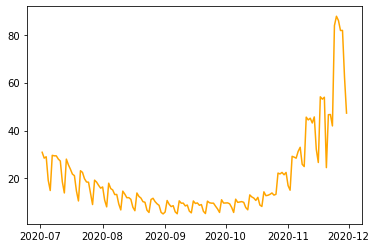

In [7]:
plt.plot(dfCaliforniaCase['Date'], dfCaliforniaCase['sum'], color = 'orange', label = 'California')


C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


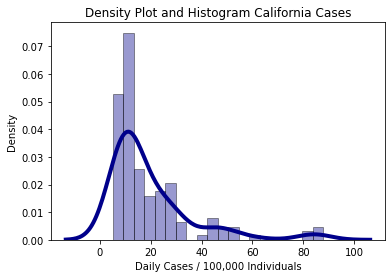

In [8]:
import seaborn as sns

sns.distplot(dfCaliforniaCase['sum'], hist=True, kde=True, 
             bins=int(100/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4});



plt.title('Density Plot and Histogram California Cases'); 
plt.xlabel('Daily Cases / 100,000 Individuals'); plt.ylabel('Density');

plt.savefig('image1.png', bbox_inches='tight')



Describe the type of distribution (modality) and its statistics (moments of a distribution - center, variance, skewness, kurtosis) in the report and the notebook.

In [9]:
from scipy.stats import skew 
from scipy.stats import kurtosis 
import statistics as stat

# Calculate the skewness 
print(skew(dfCaliforniaCase['sum'], axis=0, bias=True))
# Calculate the kurtosis 
print(kurtosis(dfCaliforniaCase['sum'], axis=0, bias=True))
print(stat.variance(dfCaliforniaCase['sum']))
print(dfCaliforniaCase['sum'].describe())

2.236467786423448
5.253425962703927
283.9115301989422
count    152.000000
mean      19.707526
std       16.849674
min        5.193330
25%        9.678651
50%       13.202244
75%       24.050153
max       87.732346
Name: sum, dtype: float64


C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with

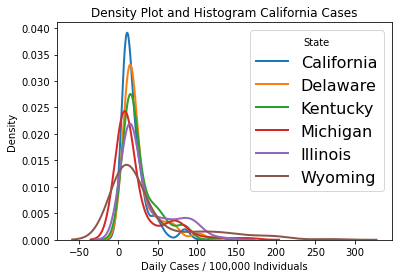

In [10]:
# Draw the density plot for each state
sns.distplot(dfCaliforniaCase['sum'], hist = False, kde = True, kde_kws = {'linewidth': 2}, label = 'California')
sns.distplot(dfDelawareCase['sum'], hist = False, kde = True, kde_kws = {'linewidth': 2}, label = 'Delaware')
sns.distplot(dfKentuckyCase['sum'], hist = False, kde = True, kde_kws = {'linewidth': 2}, label = 'Kentucky')
sns.distplot(dfMichiganCase['sum'], hist = False, kde = True, kde_kws = {'linewidth': 2}, label = 'Michigan')
sns.distplot(dfIllinoisCase['sum'], hist = False, kde = True, kde_kws = {'linewidth': 2}, label = 'Illinois')
sns.distplot(dfWyomingCase['sum'], hist = False, kde = True, kde_kws = {'linewidth': 2}, label = 'Wyoming')

# Plot formatting
plt.legend(prop={'size': 16}, title = 'State')
plt.title('Density Plot and Histogram California Cases'); 
plt.xlabel('Daily Cases / 100,000 Individuals'); plt.ylabel('Density');
plt.ylabel('Density')

plt.savefig('image2.png', bbox_inches='tight')


Graphically plot the distribution and describe the distribution statistics. If using discrete values, calculate the Probability Mass Function for the individual values or range (if using histogram) and plot that. Describe the type of distribution (modality) and its statistics (moments of a distribution - center, variance, skewness, kurtosis) in the report and the notebook. Compare the distribution and its statistics to 5 other states of your choosing. Describe if the distributions look different and what does that imply.

In [11]:
# working on table with distribution statisitics for our PDF for CASES

# Calculate the skewness 

DistStats = [["California", dfCaliforniaCase['sum'].mean(), stat.variance(dfCaliforniaCase['sum']), skew(dfCaliforniaCase['sum']),kurtosis(dfCaliforniaCase['sum'])],
    ["Delaware", dfDelawareCase['sum'].mean(), stat.variance(dfDelawareCase['sum']), skew(dfDelawareCase['sum']),kurtosis(dfDelawareCase['sum'])],
    ["Kentucky", dfKentuckyCase['sum'].mean(), stat.variance(dfKentuckyCase['sum']), skew(dfKentuckyCase['sum']),kurtosis(dfKentuckyCase['sum'])],
    ["Michigan", dfMichiganCase['sum'].mean(), stat.variance(dfMichiganCase['sum']), skew(dfMichiganCase['sum']),kurtosis(dfMichiganCase['sum'])],
    ["Illinois", dfIllinoisCase['sum'].mean(), stat.variance(dfIllinoisCase['sum']), skew(dfIllinoisCase['sum']),kurtosis(dfIllinoisCase['sum'])],
    ["Wyoming", dfWyomingCase['sum'].mean(), stat.variance(dfWyomingCase['sum']), skew(dfWyomingCase['sum']),kurtosis(dfWyomingCase['sum'])]]
 
print(DistStats)
df2 = pd.DataFrame(DistStats, columns =['State', 'Mean', 'Varience', 'Skew', 'Kurtosis'], dtype = float) 
                                                                                      
                                                                                                
print(df2.to_markdown())


[['California', 19.70752589381612, 283.9115301989422, 2.236467786423448, 5.253425962703927], ['Delaware', 24.70743478534408, 433.5119333065592, 2.0196081316002807, 3.8695812216274916], ['Kentucky', 27.25073397740896, 505.76619678723455, 1.6498027912494648, 2.6044045089175754], ['Michigan', 22.985407088958073, 971.6833094293303, 2.19882274650683, 5.007250118855131], ['Illinois', 33.55793390539113, 955.2689599513195, 1.330318510685503, 0.6091255634177086], ['Wyoming', 36.43571849422644, 2850.069952035916, 2.045510508118606, 3.6160908700022896]]
|    | State      |    Mean |   Varience |    Skew |   Kurtosis |
|---:|:-----------|--------:|-----------:|--------:|-----------:|
|  0 | California | 19.7075 |    283.912 | 2.23647 |   5.25343  |
|  1 | Delaware   | 24.7074 |    433.512 | 2.01961 |   3.86958  |
|  2 | Kentucky   | 27.2507 |    505.766 | 1.6498  |   2.6044   |
|  3 | Michigan   | 22.9854 |    971.683 | 2.19882 |   5.00725  |
|  4 | Illinois   | 33.5579 |    955.269 | 1.33032 |   

C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
# working on table with distribution statisitics for our PDF for DEATHS

# Calculate the skewness 

DistStats = [["California", dfCaliforniaDeath['sum'].mean()],
    ["Delaware", dfDelawareDeath['sum'].mean()],
    ["Kentucky", dfKentuckyDeath['sum'].mean()],
    ["Michigan", dfMichiganDeath['sum'].mean()],
    ["Illinois", dfIllinoisDeath['sum'].mean()],
    ["Wyoming", dfWyomingDeath['sum'].mean()]]
 
print(DistStats)
df2 = pd.DataFrame(DistStats, columns =['State', 'Mean'], dtype = float) 
                                                                                      
                                                                                                
print(df2.to_markdown())


[['California', 0.24411927833669114], ['Delaware', 0.25027481943419877], ['Kentucky', 0.21804912432724227], ['Michigan', 0.27234469760294694], ['Illinois', 0.3707971803491182], ['Wyoming', 0.286065381112492]]
|    | State      |     Mean |
|---:|:-----------|---------:|
|  0 | California | 0.244119 |
|  1 | Delaware   | 0.250275 |
|  2 | Kentucky   | 0.218049 |
|  3 | Michigan   | 0.272345 |
|  4 | Illinois   | 0.370797 |
|  5 | Wyoming    | 0.286065 |


Model a poission distribution of COVID-19 cases and deaths of a state and compare to other 5 states. Describe how the poission modeling is different from the first modeling you did. (25 points)

For example, number of new cases and deaths per 100,000 population. Hint - the parameter for a poission's distribution will be its mean value. Then for the minimum and maximum range of covid cases you are calculating probability mass function to observe the probability at different points.

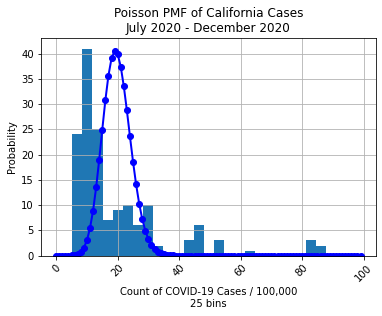

In [14]:
from scipy.stats import poisson
import matplotlib.pyplot as plt

# Histogram of daily cases

plt.hist(dfCaliforniaCase['sum'], bins = 25)

Cal = 19.7075
k_values = np.arange(0, 100)

# Calculate the PMF using the Scipy library
pmf_values = poisson.pmf(k_values, Cal)*450

plt.plot(k_values, pmf_values, 'bo-', linewidth=2)



plt.xlabel('Daily COVID-19 Cases per 100,000 Individuals in California\n25 Bins') # x axis label
plt.ylabel('Number of Occurences') # y axis label
plt.title('California COVID-19 Cases\nJuly 2020 to December 2021') # Title
plt.xticks(rotation=45) # rotate dates

# lambda is the same as the mean and the variation in a poisson distribution
# Poisson distribution is not appropriate because the mean != the varience and the data is continous not discrete. 

from scipy.stats import poisson
import matplotlib.pyplot as plt

# Plot the PMF using Matplotlib
#plt.plot(k_values, pmf_values, 'bo-', linewidth=2)

plt.xlabel('Count of COVID-19 Cases / 100,000\n25 bins')
plt.ylabel('Probability')
plt.title('Poisson PMF of California Cases\nJuly 2020 - December 2020')
plt.grid(True)
plt.savefig('image3.png', bbox_inches='tight')

plt.show()



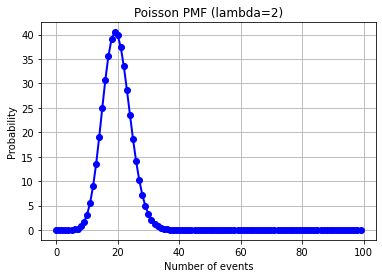

40.48168301819902


In [15]:


# Set the Poisson parameter and the range of k values
Cal = 19.7075
k_values = np.arange(0, 100)

# Calculate the PMF using the Scipy library
pmf_values = poisson.pmf(k_values, Cal)*450

# Plot the PMF using Matplotlib
plt.plot(k_values, pmf_values, 'bo-', linewidth=2)

plt.xlabel('Number of events')
plt.ylabel('Probability')
plt.title('Poisson PMF (lambda=2)')
plt.grid(True)
plt.show()

print(pmf_values.max())

C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:21: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages

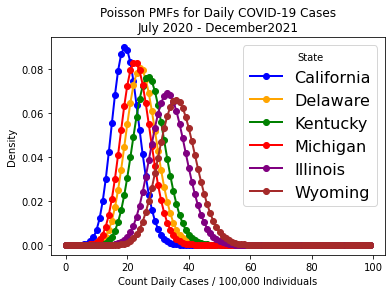

In [16]:
# Calculating comparison countries poisson

Delaware=24.7074
Kentucky=27.2507
Michigan=22.9854
Illinois=33.5579
Wyoming=36.4357

k_values = np.arange(0, 100)

# Calculate the PMF using the Scipy library
pmf_CA = poisson.pmf(k_values, Cal)
pmf_DL = poisson.pmf(k_values, Delaware)
pmf_KY=poisson.pmf(k_values, Kentucky)
pmfMI=poisson.pmf(k_values, Michigan)
pmfIL=poisson.pmf(k_values, Illinois)
pmfWY=poisson.pmf(k_values, Wyoming)

# Plot the PMF using Matplotlib
#plt.plot(k_values, pmf_values, 'bo-', linewidth=2)
plt.plot(k_values, pmf_CA, 'bo-', linewidth=2, label = 'California', color = 'blue')
plt.plot(k_values, pmf_DL, 'bo-', linewidth=2, label = 'Delaware', color = 'orange')
plt.plot(k_values, pmf_KY, 'bo-', linewidth=2, label = 'Kentucky', color = 'green')
plt.plot(k_values, pmfMI, 'bo-', linewidth=2, label = 'Michigan', color ='red')
plt.plot(k_values, pmfIL, 'bo-', linewidth=2, label = 'Illinois', color = 'purple')
plt.plot(k_values, pmfWY, 'bo-', linewidth=2, label = 'Wyoming', color = 'brown')


plt.legend(prop={'size': 16}, title = 'State')
plt.title('Poisson PMFs for Daily COVID-19 Cases\nJuly 2020 - December2021'); 
plt.xlabel('Count Daily Cases / 100,000 Individuals')
plt.ylabel('Density')

plt.savefig('image4.png',  bbox_inches='tight')

plt.show()


C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\ipykernel_launcher.py:25: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages

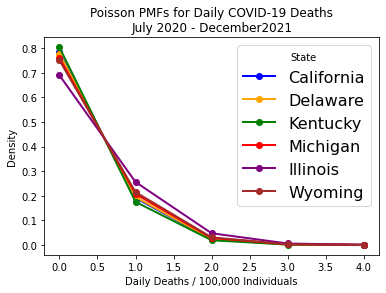

In [28]:
# Calculating comparison countries poisson

Cal =  0.244119
Delaware=0.250275
Kentucky= 0.218049
Michigan= 0.272345
Illinois=0.370797
Wyoming= 0.286065

k_values = np.arange(0,5)

# Calculate the PMF using the Scipy library
pmf_CA = poisson.pmf(k_values, Cal)
pmf_DL = poisson.pmf(k_values, Delaware)
pmf_KY=poisson.pmf(k_values, Kentucky)
pmfMI=poisson.pmf(k_values, Michigan)
pmfIL=poisson.pmf(k_values, Illinois)
pmfWY=poisson.pmf(k_values, Wyoming)

# Plot the PMF using Matplotlib
#plt.plot(k_values, pmf_values, 'bo-', linewidth=2)
plt.plot(k_values, pmf_CA, 'bo-', linewidth=2, label = 'California', color = 'blue')
plt.plot(k_values, pmf_DL, 'bo-', linewidth=2, label = 'Delaware', color = 'orange')
plt.plot(k_values, pmf_KY, 'bo-', linewidth=2, label = 'Kentucky', color = 'green')
plt.plot(k_values, pmfMI, 'bo-', linewidth=2, label = 'Michigan', color ='red')
plt.plot(k_values, pmfIL, 'bo-', linewidth=2, label = 'Illinois', color = 'purple')
plt.plot(k_values, pmfWY, 'bo-', linewidth=2, label = 'Wyoming', color = 'brown')


plt.legend(prop={'size': 16}, title = 'State')
plt.title('Poisson PMFs for Daily COVID-19 Deaths\nJuly 2020 - December2021'); 
plt.xlabel('Daily Deaths / 100,000 Individuals')
plt.ylabel('Density')

plt.savefig('image5.png', bbox_inches='tight')

plt.show()




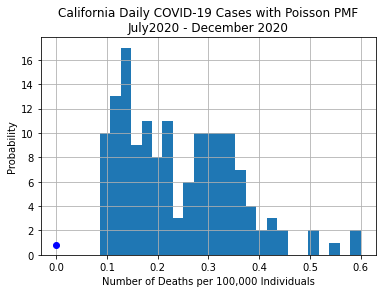

In [18]:
# Set the Poisson parameter and the range of k values 
plt.hist(dfCaliforniaDeath['sum'], bins = 25)


k_values = np.arange(0, 1)
pmf_CA = poisson.pmf(k_values, Cal)

# Plot the PMF using Matplotlib
plt.plot(k_values, pmf_CA, 'bo-', linewidth=2)
plt.xlabel('Number of Deaths per 100,000 Individuals')
plt.ylabel('Probability')
plt.title('California Daily COVID-19 Cases with Poisson PMF\nJuly2020 - December 2020')
plt.grid(True)
plt.show()

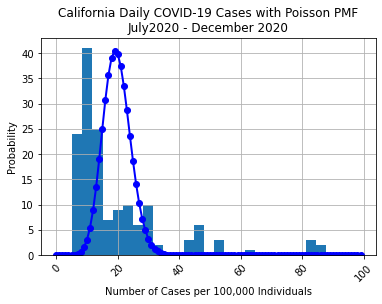

In [19]:
# Set the Poisson parameter and the range of k values
plt.hist(dfCaliforniaCase['sum'], bins = 25)

plt.xticks(rotation=45) # rotate dates
lam = 19.7075
k_values = np.arange(0, 100)

# Calculate the PMF using the Scipy library
pmf_values = poisson.pmf(k_values, lam)*450

# Plot the PMF using Matplotlib
plt.plot(k_values, pmf_values, 'bo-', linewidth=2)
plt.xlabel('Number of Cases per 100,000 Individuals')
plt.ylabel('Probability')
plt.title('California Daily COVID-19 Cases with Poisson PMF\nJuly2020 - December 2020')
plt.grid(True)
plt.show()

In [20]:
# Transforming cases to log cases

import math
dfCaliforniaCase['log_Cases'] = np.log10(dfCaliforniaCase['sum'])
dfDelawareCase['log_Cases'] = np.log10(dfDelawareCase['sum'])
dfKentuckyCase['log_Cases'] = np.log10(dfKentuckyCase['sum'])
dfMichiganCase['log_Cases'] = np.log10(dfMichiganCase['sum'])
dfIllinoisCase['log_Cases'] = np.log10(dfIllinoisCase['sum'])
dfWyomingCase['log_Cases'] = np.log10(dfWyomingCase['sum'])

# MinMax Case Values


dfCaliforniaCase.head()

C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Date,nullcounts,sum,mean,median,max,State,log_Cases
169,2020-07-02,0.0,30.932200,0.515537,0.117685,9.030117,California,1.490411
170,2020-07-03,0.0,28.487387,0.474790,0.096173,8.141784,California,1.454653
171,2020-07-04,0.0,29.061893,0.484365,0.092376,8.270858,California,1.463324
172,2020-07-05,0.0,19.244678,0.320745,0.064537,6.119625,California,1.284311
173,2020-07-06,0.0,14.967520,0.249459,0.075926,4.345491,California,1.175150


(array([0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

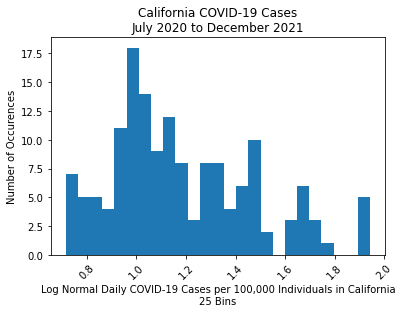

In [21]:
# histogramming log value for cases

plt.hist(dfCaliforniaCase['log_Cases'], bins = 25)


plt.xlabel('Log Normal Daily COVID-19 Cases per 100,000 Individuals in California\n25 Bins') # x axis label
plt.ylabel('Number of Occurences') # y axis label
plt.title('California COVID-19 Cases\nJuly 2020 to December 2021') # Title
plt.xticks(rotation=45) # rotate dates


In [22]:
# working on table with distribution statisitics for our PDF

# Calculate the skewness 

DistStats = [["California", dfCaliforniaCase['log_Cases'].mean(), stat.variance(dfCaliforniaCase['log_Cases']), skew(dfCaliforniaCase['log_Cases']),kurtosis(dfCaliforniaCase['log_Cases'])],
    ["Delaware", dfDelawareCase['log_Cases'].mean(), stat.variance(dfDelawareCase['log_Cases']), skew(dfDelawareCase['log_Cases']),kurtosis(dfDelawareCase['log_Cases'])],
    ["Kentucky", dfKentuckyCase['log_Cases'].mean(), stat.variance(dfKentuckyCase['log_Cases']), skew(dfKentuckyCase['log_Cases']),kurtosis(dfKentuckyCase['log_Cases'])],
    ["Michigan", dfMichiganCase['log_Cases'].mean(), stat.variance(dfMichiganCase['log_Cases']), skew(dfMichiganCase['log_Cases']),kurtosis(dfMichiganCase['log_Cases'])],
    ["Illinois", dfIllinoisCase['log_Cases'].mean(), stat.variance(dfIllinoisCase['log_Cases']), skew(dfIllinoisCase['log_Cases']),kurtosis(dfIllinoisCase['log_Cases'])],
    ["Wyoming", dfWyomingCase['log_Cases'].mean(), stat.variance(dfWyomingCase['log_Cases']), skew(dfWyomingCase['log_Cases']),kurtosis(dfWyomingCase['log_Cases'])]]
 
print(DistStats)
df2 = pd.DataFrame(DistStats, columns =['State', 'Mean', 'Varience', 'Skew', 'Kurtosis'], dtype = float) 
                                                                                      
                                                                                                
print(df2.to_markdown())

[['California', 1.1853115116568884, 0.08435186506463026, 0.6861186009284177, -0.14899800334177726], ['Delaware', -inf, nan, nan, nan], ['Kentucky', -inf, nan, nan, nan], ['Michigan', -inf, nan, nan, nan], ['Illinois', 1.3685837421025693, 0.12814968993052397, 0.5492078089791381, -0.9403435555281936], ['Wyoming', -inf, nan, nan, nan]]
|    | State      |       Mean |    Varience |       Skew |   Kurtosis |
|---:|:-----------|-----------:|------------:|-----------:|-----------:|
|  0 | California |    1.18531 |   0.0843519 |   0.686119 |  -0.148998 |
|  1 | Delaware   | -inf       | nan         | nan        | nan        |
|  2 | Kentucky   | -inf       | nan         | nan        | nan        |
|  3 | Michigan   | -inf       | nan         | nan        | nan        |
|  4 | Illinois   |    1.36858 |   0.12815   |   0.549208 |  -0.940344 |
|  5 | Wyoming    | -inf       | nan         | nan        | nan        |


C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\scipy\stats\stats.py:951: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
C:\Users\leena\anaconda3\envs\MSIA\lib\site-packages\IPython\core\interactiveshell.py:3457: FutureWarning: Could not cast to float64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised
  exec(code_obj, self.user_global_ns, self.user_ns)


Perform corelation between Enrichment data valiables and COVID-19 cases to observe any patterns. (20 points)

You can compare either within your chosen specific state or among different states with the different enrichment variables. Within the state you can compare the county based covid data to enrichment data for correlation. Between states you would need to aggregate to state level data and then perform correlation. Both covid and enrichment data will need to be normalized for population. For number of covid cases you can use a measure of center value (median or mean) to compare the number of cases. Formulate hypothesis between Enrichment data and number of cases to be compared against states. Choose 3 different variables to compare against. (30 points)

For example: Does higher employment data lead to higher covid case numbers or more rapid increase in covid cases.

In [23]:
df = pd.read_csv('EnrichmentData.csv')

df.head()

,Unnamed: 0,Cases,CountyFIPS,County Name,State,StateFIPS,Date,Deaths,population,GasolinePrice
0,0,0,0,Statewide Unallocated,AL,1,2020-01-22,0,0.0,2.567
1,1,0,1001,Autauga County,AL,1,2020-01-22,0,55869.0,2.567
2,2,0,1003,Baldwin County,AL,1,2020-01-22,0,223234.0,2.567
3,3,0,1005,Barbour County,AL,1,2020-01-22,0,24686.0,2.567
4,4,0,1007,Bibb County,AL,1,2020-01-22,0,22394.0,2.567


In [24]:
dfCalifornia = df[df['State']=='CA']

dfCalifornia = dfCalifornia.groupby(['Date', 'GasolinePrice'], as_index = False)['Cases'].sum()

# Triming dates
dfCalifornia = dfCalifornia[(dfCalifornia['Date'] > "2020-01-01") & (dfCalifornia['Date'] < "2020-12-01")]


# Repeating for rest of states
dfDelaware = df[df['State']=='DE']
dfDelaware = dfDelaware.groupby(['Date', 'GasolinePrice'], as_index = False)['Cases'].sum()
dfDelaware = dfDelaware[(dfDelaware['Date'] > "2020-01-01") & (dfDelaware['Date'] < "2020-12-01")]

dfKentucky = df[df['State']=='KY']
dfKentucky = dfKentucky.groupby(['Date', 'GasolinePrice'], as_index = False)['Cases'].sum()
dfKentucky = dfKentucky[(dfKentucky['Date'] > "2020-01-01") & (dfKentucky['Date'] < "2020-12-01")]

dfMichigan = df[df['State']=='MI']
dfMichigan = dfKentucky.groupby(['Date', 'GasolinePrice'], as_index = False)['Cases'].sum()
dfMichigan = dfMichigan[(dfMichigan['Date'] > "2020-01-01") & (dfMichigan['Date'] < "2020-12-01")]

dfIllinois = df[df['State']=='IL']
dfIllinois = dfIllinois.groupby(['Date', 'GasolinePrice'], as_index = False)['Cases'].sum()
dfIllinois = dfIllinois[(dfIllinois['Date'] > "2020-01-01") & (dfIllinois['Date'] < "2020-12-01")]

dfWyoming = df[df['State']=='WY']
dfWyoming = dfWyoming.groupby(['Date', 'GasolinePrice'], as_index = False)['Cases'].sum()
dfWyoming = dfWyoming[(dfWyoming['Date'] > "2020-01-01") & (dfWyoming['Date'] < "2020-12-01")]


In [25]:
dfKentucky.head()

,Date,GasolinePrice,Cases
0,2020-01-22,2.567,0
1,2020-01-23,2.567,0
2,2020-01-24,2.567,0
3,2020-01-25,2.567,0
4,2020-01-26,2.567,0


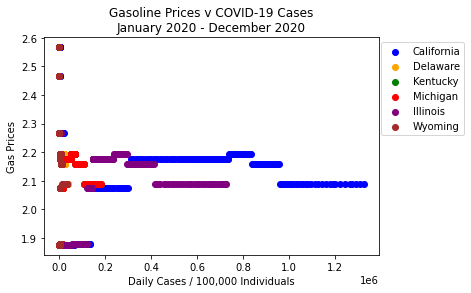

In [30]:
#matplotlib.pyplot.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs)

plt.scatter(dfCalifornia['Cases'], dfCalifornia['GasolinePrice'], label = 'California', color = 'blue')
plt.scatter(dfDelaware['Cases'], dfDelaware['GasolinePrice'], label = 'Delaware', color = 'orange')
plt.scatter(dfKentucky['Cases'], dfKentucky['GasolinePrice'], label = 'Kentucky', color = 'green')
plt.scatter(dfMichigan['Cases'], dfMichigan['GasolinePrice'], label = 'Michigan', color = 'red')
plt.scatter(dfIllinois['Cases'], dfIllinois['GasolinePrice'], label = 'Illinois', color = 'purple')
plt.scatter(dfWyoming['Cases'], dfWyoming['GasolinePrice'], label = 'Wyoming', color = 'Brown')

plt.legend(prop={'size': 16}, title = 'State')
plt.title('Gasoline Prices v COVID-19 Cases\nJanuary 2020 - December 2020'); 
plt.xlabel('Daily Cases / 100,000 Individuals')
plt.ylabel('Gas Prices')
plt.legend(bbox_to_anchor=(1.27,1))

plt.savefig('image6.png',  bbox_inches='tight')

plt.show()

In [27]:
from IPython.display import Image



# Stage 3 Analysis

## Probability Denisty Functions

Below is a histogram of the California case data (from July 2020 - December 2020).  The shape is right skewed, and therefore does not exhibit a normal shape.  The kernal density estimator was used to approximate the PDF for the California cases within that range.

![California](image1.png "Title")
<div style="text-align: center"> Figure 1 </div>


To give addional context to the California data, the PDFs from mulitple states were compared. The histograms were not included for clarity.  The shapes of the PDFs for each state are quite similar, however the peak at the probalities of ~ 10 COVID cases / 100,000 individuals are quite different.

![PDF_Comparison](image2.png "Title")
<div style="text-align: center"> Figure 2 </div>


The moments of distribution from figure 2 are compared in the below table.  These statistics give more context to the graph, and confirm what can be seen clearly:
    1) All of the states have positively skewed data
    2) The varience and mean vary amoung the states, but they are never equal, which indicates that this data in not normally ditributed
    3) Kurtosis exists in all of the states, but it is the least prevelant in Illinois
    

|    | State      |    Mean |   Varience |    Skew |   Kurtosis |
|---:|:-----------|--------:|-----------:|--------:|-----------:|
|  0 | California | 19.7075 |    283.912 | 2.23647 |   5.25343  |
|  1 | Delaware   | 24.7074 |    433.512 | 2.01961 |   3.86958  |
|  2 | Kentucky   | 27.2507 |    505.766 | 1.6498  |   2.6044   |
|  3 | Michigan   | 22.9854 |    971.683 | 2.19882 |   5.00725  |
|  4 | Illinois   | 33.5579 |    955.269 | 1.33032 |   0.609126 |
|  5 | Wyoming    | 36.4357 |   2850.07  | 2.04551 |   3.61609  |

<div style="text-align: center"> Table 1 </div>

In the next section, instead of utilizing the KDE within seaborn, the probability denisty is estimated within the model of a Poisson distribution.  As you can see, the peak of  this graph, which is based on the mean, does not align with the peak of the actual data.  This indicates that a Poisson model is not the best for this COVID-19 data, as the mean and the variences are very different.  A different model will be a better choice.
![Poisson_PMF_Comparison](image3.png "Title")
<div style="text-align: center"> Figure 3 </div>

Once again, the comparison of individual states Poisson PMF's were compared.  The same issues of divergence in the mean and varience occures in each state - none of them follow a Poisson distribution.

![Poisson_PMF_Comparison](image4.png "Title")
<div style="text-align: center"> Figure 4 </div>

The same Poisson PMF exercise was completed on the COVID-19 Death Data, which exhibits very similar shapes across the states.  
![Poisson_PMF_Comparison](image5.png "Title")
<div style="text-align: center"> Figure 5 </div>


## Enrichment Data
I pulled date from the Bureau of Laber Statistics on gasoline data from January 2020 to July 2023.  I was interested in looking at the relationship between gas prices and COVID-19 cases, especially during the pre-vaccination part of the COVID-19 Pandemic (before ~ April 2021).  Gas prices tanked at the start of the pandemic as the entire world came to a hault.  They ebbed and flowed over the coming months as the nature of the pandemic changed.

Below is a scatter plot of gas prices v COVID-19 cases for all of the states we have evaluated so far.  

![Poisson_PMF_Comparison](image6.png "Title")
<div style="text-align: center"> Figure 6</div>

Note, the stair step nature of this graph is due to only having monthly data for Gasoline prices.  From this graph, I do see some outliers that need investigation and may be excluded if justification is found.  Otherwise the data approximates a log curve.  My next steps before hypothesis testing will be to try to transform this data so it has more of a linear relationship.  My current hypothesis to test are:
    Ho: High COVID-19 cases is not correlated  low Gas Prices during 2020
    Ha: HIgh COVID-19 cases is correlated with low gas prices during 2020 

I will use different indicators for "high" COVID-19 cases.  The graph above is simply the sum of cases across all counties for each state.  I will create new datasets to test the same hypotheses on to look at the median and mean cases v gas prices.



In [ ]:
# End of stage 3